In [1]:
"""
Causal Inferece on Pricing Strategy & Customer Demand using DoWhy & NetworkX
---

🔍 **Situation**:
- Create a synthetic dataset for a retail pricing problem where we analyze the causal effects of a price change on customer demand
- Understand relationship between product price, advertising spend, competitor pricing, and customer demand

📌 **Task**:
- Create synthetic retail pricing dataset
- Design a causal graph based on domain knowledge
- Perform causal discovery using DoWhy

✨ **Action**: 
- This methodology was valuable in determining the cause of a revenue drop

📈 **Result**:
- Run some more tests to determine causality using the DAG

✍ **Author**: Justin Wall
📅 **Updated**: 03/04/2025
"""

'\nCausal Inferece on Pricing Strategy & Customer Demand using DoWhy & NetworkX\n---\n\n🔍 **Situation**:\n- Create a synthetic dataset for a retail pricing problem where we analyze the causal effects of a price change on customer demand\n- Understand relationship between product price, advertising spend, competitor pricing, and customer demand\n\n📌 **Task**:\n- Create synthetic retail pricing dataset\n- Design a causal graph based on domain knowledge\n- Perform causal discovery using DoWhy\n\n✨ **Action**: \n- This methodology was valuable in determining the cause of a revenue drop\n\n📈 **Result**:\n- Run some more tests to determine causality using the DAG\n\n✍ **Author**: Justin Wall\n📅 **Updated**: 03/04/2025\n'

In [2]:
# ================================= #
# Generate Fake Retail Pricing Data #
# ================================= #
#%%
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Number of observations
n = 1000  

# Generate features
ad_spend = np.random.uniform(1000, 5000, n)  # Ad budget
competitor_price = np.random.uniform(10, 50, n)  # Competitor pricing
price = np.random.uniform(15, 55, n)  # Our product price

# Define true causal mechanisms
# Competitor price influences our price strategy
price = price - 0.3 * competitor_price + np.random.normal(0, 2, n)

# Ad spend influences both our price strategy and sales
sales = 500 - 5 * price + 0.1 * ad_spend + 3 * competitor_price + np.random.normal(0, 10, n)

# Create DataFrame
df = pd.DataFrame({"price": price, "ad_spend": ad_spend, "competitor_price": competitor_price, "sales": sales})

df.head()
#%%

,price,ad_spend,competitor_price,sales
0,22.366505,2498.160475,17.405317,685.005510
1,16.610352,4802.857226,31.676038,988.852995
2,39.141972,3927.975767,44.917833,836.124385
3,10.463238,3394.633937,39.288995,905.785755
4,15.623143,1624.074562,42.262446,705.140964


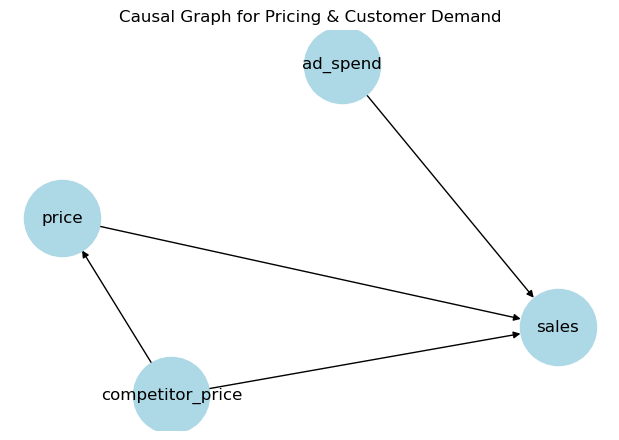

In [3]:
# ================================= #
# Create Causal Graph               #
# ================================= #
#%%
# Define causal relationships
causal_graph = nx.DiGraph()
causal_graph.add_edges_from([
    ("ad_spend", "sales"),
    ("competitor_price", "price"),
    ("competitor_price", "sales"),
    ("price", "sales")
])
# Draw up relationships using domain knowledge

# Plot the causal graph
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(causal_graph, seed=42)
nx.draw(causal_graph, pos, with_labels=True, node_color="lightblue", edge_color="black", node_size=3000, font_size=12)
plt.title("Causal Graph for Pricing & Customer Demand")
plt.show()
#%%

In [4]:
# ================================= #
# Perform Causal Discovery w/DoWhy  #
# ================================= #
#%%
from dowhy import gcm
from dowhy.gcm import InvertibleStructuralCausalModel, fit

# Define causal model
model = InvertibleStructuralCausalModel(causal_graph)

# Assign causal mechanisms (Gaussian Processes for simplicity)
gcm.auto.assign_causal_mechanisms(model, df)

# Train causal model
fit(model, df)
#%%

Fitting causal mechanism of node price: 100%|██████████| 4/4 [00:00<00:00, 675.06it/s]  


In [5]:
# ================================= #
# Evaluate Causal Graph             #
# ================================= #
#%%

gcm.evaluate_causal_model(
    model,
    df,
    compare_mechanism_baselines=True,
    evaluate_invertibility_assumptions=True,
)
#%%
# PNL Assumption for sales and price is (1.0, False, 0.05)
# 1.0 → Suggests that a nonlinear causal relationship might be necessary.
# False → Indicates that no strong violation of the assumption was detected.
# 0.05 → Significance level used for the test.
# ✅ Interpretation: Your causal model is not strongly rejecting the assumption, but the relationships may be somewhat nonlinear. If the model performance is poor, consider using nonparametric methods (e.g., Gaussian Processes) instead of linear models.
# DoWhy tests 24 different DAG permutations to check if your causal graph is part of the Markov equivalence class (i.e., a valid structure).
# 2/24 permutations were equivalent to your DAG.
# p-value: 0.08 means there is no strong evidence against your graph, though it's not highly robust either.
# ✅ Interpretation: Your DAG is informative and likely close to the true causal structure, but there might be alternative DAGs that fit nearly as well.
# No violations of Local Markov Conditions (0/4 LMCs) → Your causal relationships follow conditional independence rules.
# Your DAG is better than 91.7% of alternative DAGs.
# p-value: 0.08 → Indicates the DAG fits well but is not statistically “perfect”.
# ✅ Interpretation: Your DAG is statistically valid under this test.
# The model is not strongly rejected, meaning your assumed causal directions are likely correct.
# Since the significance threshold was 0.2 (a common setting), your DAG passes the test.

Evaluating causal mechanisms...: 100%|██████████| 4/4 [00:00<00:00, 4034.92it/s]


TypeError: got an unexpected keyword argument 'squared'

In [ ]:
# ================================= #
# Attribution Analysis              #
# ================================= #
#%%
# Define the anomaly (a revenue drop)
# anomalous_point = {"sales": df["sales"].iloc[725]}  # Selecting a known anomalous drop
anomalous_point = {
    "sales": df["sales"].iloc[725],
    "price": df["price"].iloc[725],
    "ad_spend": df["ad_spend"].iloc[725],  # Ensure this is included
    "competitor_price": df["competitor_price"].iloc[725],
}

# Compute confidence intervals for anomaly attributions
median_attributions, confidence_intervals = gcm.confidence_intervals(
   gcm.fit_and_compute(
       gcm.attribute_anomalies,    # Function to attribute anomalies
       model,                        # Structural causal model
       bootstrap_training_data=df, # Training data for bootstrapping
       target_node="sales",      # Target variable for anomaly attribution
       anomaly_samples=pd.DataFrame([anomalous_point])  # The anomaly to analyze
   ),
   num_bootstrap_resamples=10  # Number of bootstrap resamples for confidence intervals
)
#%%

In [ ]:
# ================================= #
# Visualize Attributions            #
# ================================= #
#%%
# Helper function to plot attributions
def bar_plot(median_attributions, confidence_intervals, title):
    plt.figure(figsize=(8, 5))
    
    # Extract the lower and upper bounds of the confidence intervals
    lower_bounds = {key: confidence_intervals[key][0] for key in confidence_intervals}
    upper_bounds = {key: confidence_intervals[key][1] for key in confidence_intervals}
    
    # Convert dict_values to NumPy arrays
    median_values = np.array(list(median_attributions.values()))
    lower_values = np.array(list(lower_bounds.values()))
    upper_values = np.array(list(upper_bounds.values()))
    
    # Calculate the error bars
    yerr = [
        median_values - lower_values,
        upper_values - median_values
    ]
    
    plt.bar(median_attributions.keys(), median_values, yerr=yerr, capsize=5, color="royalblue", alpha=0.7)
    plt.xlabel("Factors")
    plt.ylabel("Anomaly Attribution Score")
    plt.title(title)
    plt.xticks(rotation=30)
    plt.show()

# Plot the anomaly attribution scores with confidence intervals
bar_plot(median_attributions, confidence_intervals, "Revenue Anomaly Attribution")
#%%